In [52]:
import torch
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import utils_funcs as futil

In [53]:
torch.set_default_dtype(torch.float64)
torch.set_printoptions(precision=3)  # show 3 decimal places

In [54]:
save_fig = False
figsize1 = (4,3)
figsize2 = (4,5)
figsize3 = (4,8)

In [55]:
model = 'exponential'
#model = 'logistic'
#model = 'gompertz'
DIV_GOMP = 5.

# number of variants
K = 4

# Carrying capacity as fold of initial cell density
K_N0 = torch.log(torch.tensor(1e3)) 

# Experimental time points
times = torch.tensor([0, 3, 6, 12, 18], dtype=torch.float32)
T = len(times)

In [56]:
# ---- Plotting ----
if K < 11:
    colors = plt.cm.tab10(np.linspace(0, 1, K))
else:
    colors = plt.cm.tab20(np.linspace(0, 1, K))
    
# Define a list of markers
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'P', '*', 'X']

# Generate variant read counts

### Randomly select slope and intercept for the variants

In [57]:
seed = torch.seed()      # whatever PyTorch just pulled from /dev/urandom
seed = 12209780870953886438
print("Seed is:", seed)
torch.manual_seed(seed)

# ---- Random fitness and intercepts ----
# growth rates
lambda_mean = torch.tensor(0.05) # per hour
lambda_random = torch.sort(torch.normal(lambda_mean, 0.8, size=(K,)), descending=True).values
growth_rates_true = lambda_mean + lambda_random

# GOMPERTZ reduce growth rates
if model == 'gompertz':
    growth_rates_true /= DIV_GOMP

# initial log abundances
log_abundances_true = torch.normal(0,0.5, size=(K,))
# normalize such that initial cell denisty is 1
shift = torch.logsumexp(log_abundances_true,dim=0)
log_abundances_true -= shift

#check
print("Initial density:",torch.exp(log_abundances_true).sum().item())
print("          growth rates:", growth_rates_true)
if model == 'exponential':
    print(" zero sum growth rates:", growth_rates_true-growth_rates_true.mean())
    print(growth_rates_true[:-1] - growth_rates_true[1:])
print("initial log abundances:", log_abundances_true)
f_init = torch.softmax(log_abundances_true,dim=0)
print("initial fraction:", f_init)

Seed is: 12209780870953886438
Initial density: 1.0
          growth rates: tensor([ 0.600,  0.361,  0.301, -0.137])
 zero sum growth rates: tensor([ 0.319,  0.080,  0.019, -0.418])
tensor([0.238, 0.061, 0.438])
initial log abundances: tensor([-0.955, -1.363, -2.026, -1.481])
initial fraction: tensor([0.385, 0.256, 0.132, 0.227])


In [58]:
params_true = [growth_rates_true,log_abundances_true]

## Integrate growth dynamics

### Set time variables

In [59]:
# Fine-grained time to integrate the dynamics
pntN = int(times[-1])*10+1
times_fine = torch.linspace(times[0], times[-1], steps=pntN)

# Find the matching indices between the fine-grained and experimental time points
selected_indices = torch.tensor([
    torch.argmin(torch.abs(times_fine - t)).item()
    for t in times
])

# output
print("Selected indices:", selected_indices)
print(times_fine[selected_indices])
print(times)

params_time = [times_fine,selected_indices]

Selected indices: tensor([  0,  30,  60, 120, 180])
tensor([ 0.,  3.,  6., 12., 18.])
tensor([ 0.,  3.,  6., 12., 18.], dtype=torch.float32)


### Check if dynamics works with both shapes [K] and [K,M]

In [60]:
models = ['exponential','logistic','gompertz']
selection_bools = [False,True]
noise_bools = [True,False]

futil.check_dynamics(models, K_N0,selection_bools,noise_bools,params_true,params_time)

>> exponential
     with noise
ys_fine: torch.Size([4, 8, 181])
ys_fine: torch.Size([4, 8, 5])
     without noise
ys_fine: torch.Size([4, 181])
ys_fine: torch.Size([4, 5])
>> logistic
     with noise
ys_fine: torch.Size([4, 8, 181])
ys_fine: torch.Size([4, 8, 5])
     without noise
ys_fine: torch.Size([4, 181])
ys_fine: torch.Size([4, 5])
>> gompertz
     with noise
ys_fine: torch.Size([4, 8, 181])
ys_fine: torch.Size([4, 8, 5])
     without noise
ys_fine: torch.Size([4, 181])
ys_fine: torch.Size([4, 5])


### Calculate growth curves of variants

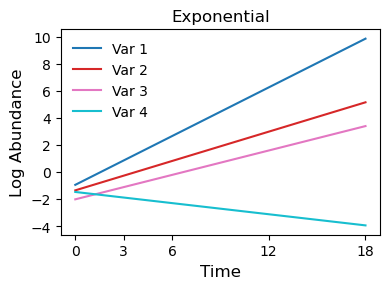

In [61]:
fig = futil.plot_log_abundance(params_true,params_time,model, K_N0,colors,figsize=figsize1)

save_fig = False
if save_fig:
    plt.savefig(f'figs/fig1a_{model}.png', dpi=300, bbox_inches='tight', transparent=True)

### Generate reads from a multinomial distribution

Seed is: 9575438959115982149
total reads:
 [412, 375, 398, 399, 421]
variant reads:
 [[184 245 331 381 416]
 [ 97  77  51  16   5]
 [ 49  36  13   2   0]
 [ 82  17   3   0   0]]


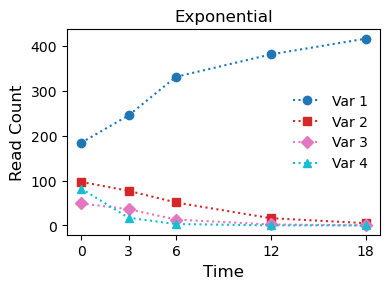

In [104]:
# calculate fractions
ys_true = futil.dynamics_selected_times(model,K_N0,times_fine,selected_indices,growth_rates_true,log_abundances_true)
fracs_true = torch.softmax(ys_true,dim=0)

# Mean value of total reads per time point
lambda_ = 100*K

seed = torch.seed()      # whatever PyTorch just pulled from /dev/urandom
seed = 9575438959115982149
print("Seed is:", seed)
torch.manual_seed(seed)

# Sample total reads per timepoint from Poisson
reads_tot = torch.poisson(torch.full((T,), lambda_, dtype=torch.float32))

# Initialize reads tensor
reads = torch.zeros((K, T), dtype=torch.float32)
# Sample Multinomial reads for each time point
for t in range(T):
    if reads_tot[t] > 0:
        # Multinomial expects probabilities to sum to 1 and counts as int
        reads[:, t] = torch.multinomial(fracs_true[:, t], int(reads_tot[t].item()), replacement=True).bincount(minlength=K)
    else:
        reads[:, t] = 0  # zero reads

# print generated counts
print("total reads:\n", reads_tot.int().tolist())
print("variant reads:\n", reads.int().numpy())

fig = futil.plot_read_counts(reads,times,model,colors,markers,figsize=figsize1,ylog=False)

## Single-time Maximum Likelihood estimation

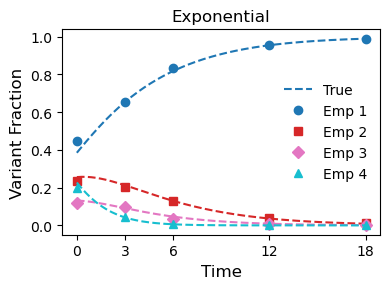

In [63]:
fig = futil.plot_empirical(reads,params_true,params_time,model,K_N0,colors,markers,figsize=figsize1)

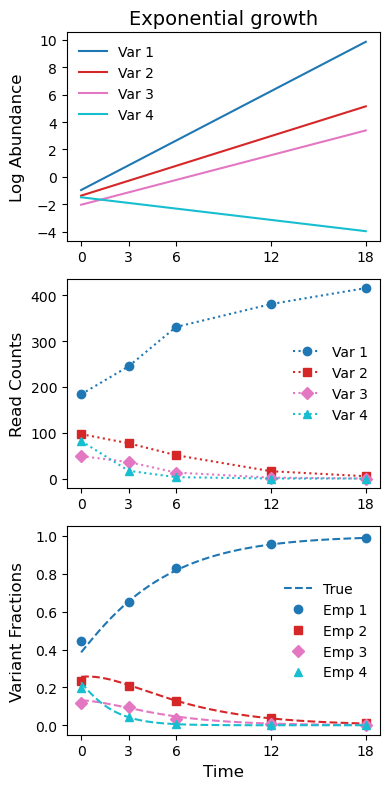

In [64]:
fig = futil.plot_logAbd_readCnt_Emp(reads,params_true,params_time,model,K_N0,colors,markers,figsize=figsize3)

save_fig = True
if save_fig:
    plt.savefig(f'figs/fig2_{model}.pdf', bbox_inches='tight')

In [65]:
#stop

# Two time points - Exponential growth

In [66]:
if model == 'exponential':
    n0 = reads[:,0]
    n1 = reads[:,2]
    t1 = times[2]

    diff_ML = torch.zeros(K,K)
    diff_LB = torch.zeros(K,K)
    diff_var = torch.zeros(K,K)

    lam_ML = torch.log(n1/n0)/t1
    lam_LB = (torch.log(n1/n0) - 0.5/n1)/t1
    var_lam = 1./(t1**2 * n1)

    for rho in range(K):
        for k in range(K):
            diff_ML[k,rho] = (torch.log(n1[k]/n1[rho]) - torch.log(n0[k]/n0[rho]))/t1
            diff_LB[k,rho] = (torch.log(n1[k]/n1[rho]) - torch.log(n0[k]/n0[rho]) -0.5*(1/n1[k] - 1/n1[rho]))/t1

            if k != rho:
                diff_var[k,rho] = var_lam[k] + var_lam[rho]

    print(diff_ML,"\n")
    print(diff_LB)
    print(torch.sqrt(diff_var),"\n")

    print("ML, T=2")
    print(lam_ML)
    print(lam_ML - torch.mean(lam_ML),"\n")
    print("LB, T=2")
    print(lam_LB)
    print(lam_LB - torch.mean(lam_LB))
    print(torch.sqrt(var_lam))

tensor([[ 0.000,  0.205,  0.319,  0.649],
        [-0.205,  0.000,  0.114,  0.444],
        [-0.319, -0.114,  0.000,  0.330],
        [-0.649, -0.444, -0.330,  0.000]]) 

tensor([[ 0.000,  0.206,  0.325,  0.677],
        [-0.206,  0.000,  0.119,  0.470],
        [-0.325, -0.119,  0.000,  0.352],
        [-0.677, -0.470, -0.352,  0.000]])
tensor([[0.000, 0.025, 0.047, 0.097],
        [0.025, 0.000, 0.052, 0.099],
        [0.047, 0.052, 0.000, 0.107],
        [0.097, 0.099, 0.107, 0.000]]) 

ML, T=2
tensor([ 0.098, -0.107, -0.221, -0.551], dtype=torch.float32)
tensor([ 0.293,  0.088, -0.026, -0.356], dtype=torch.float32) 

LB, T=2
tensor([ 0.098, -0.109, -0.228, -0.579], dtype=torch.float32)
tensor([ 0.302,  0.096, -0.023, -0.375], dtype=torch.float32)
tensor([0.009, 0.023, 0.046, 0.096], dtype=torch.float32)


# Maximum Likelihood - All time points

### Check if log likelihood function works with both shapes [K] and [K,M]

In [67]:
noises = [False,True]

for noise in noises:
    if noise:
        M = 8
        eps = torch.randn(K,M)
        sigmas = 0.03*torch.ones(K,) # K x 1
        lams = growth_rates_true[:,None] + sigmas[:,None]*eps
        dels = log_abundances_true[:,None] + sigmas[:,None]*eps
    else:
        lams = growth_rates_true
        dels = log_abundances_true
        
    ll = futil.calc_loglikelihood(model,K_N0,reads, times_fine, selected_indices, lams, dels)
    print("loglike:",ll.shape)

loglike: torch.Size([])
loglike: torch.Size([])


In [68]:
lr = 0.01
tol_loss = 1e-12
tol_vals = 1e-10
num_iterations=8000

growth_rates_ML, log_abundances_ML, history_ML = futil.optimize_LogLike(reads, params_time, model, K_N0,  
                                         lr=lr,tol=(tol_loss,tol_vals), num_iterations=num_iterations)
params_ML = [growth_rates_ML,log_abundances_ML]

Initial Params : lams = [0.100000, 0.100000, 0.100000, 0.100000], dels = [-1.386294, -1.386294, -1.386294, -1.386294]]
Iteration     0: lams = [0.015000, -0.005000, -0.005000, -0.005000], dels = [-1.371332, -1.391332, -1.391332, -1.391332]]
Iteration   800: lams = [0.296524, 0.083907, -0.025353, -0.355078], dels = [-0.841678, -1.429147, -2.039821, -1.612202]]
Converged at iteration 1600 with diff_loss 2.27373675443232e-13 and diff_val 9.960166e-11
Final grads  : lams = [-0.000000, -0.000000, -0.000000, 0.000000], dels = [0.000000, 0.000000, 0.000000, -0.000000]]
Final Params : lams = [0.296802, 0.084173, -0.025013, -0.355962], dels = [-0.841944, -1.429301, -2.040212, -1.611187]]


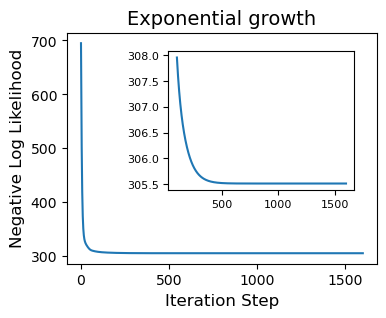

In [69]:
inset_start = 100

fig = futil.plot_History(history_ML,model,inset_start,figsize=figsize1)

save_fig = True
if save_fig:
    plt.savefig(f'figs/figS4_{model}.pdf', bbox_inches='tight')

In [70]:
print("True:")
print(growth_rates_true-growth_rates_true.mean())
print(growth_rates_true)
print("ML:")
print(growth_rates_ML)
#
if model == 'gompertz':
    print(DIV_GOMP*growth_rates_ML)
print("\n")
print(log_abundances_true-log_abundances_true.mean())
print(log_abundances_ML-log_abundances_ML.mean())

True:
tensor([ 0.319,  0.080,  0.019, -0.418])
tensor([ 0.600,  0.361,  0.301, -0.137])
ML:
tensor([ 0.297,  0.084, -0.025, -0.356])


tensor([ 0.501,  0.094, -0.570, -0.025])
tensor([ 0.639,  0.051, -0.560, -0.131])


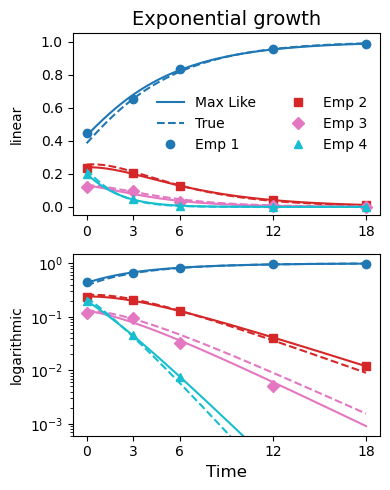

In [71]:
fig = futil.plot_fractions(reads,params_true,params_ML,['True','Max Like'],params_time,
                                   model,K_N0,colors,markers,
                                   figsize=figsize2,ylabel=False)
save_fig = True
if save_fig:
    plt.savefig(f'figs/fig4_{model}.pdf', bbox_inches='tight')

In [72]:
#stop

# Variational Inference - All time points

In [73]:
num_steps = int(500)
lr = 0.03
M =  100  # Monte Carlo samples
F = 100  # Final averaging window

growth_rates_VB,sigmasL_VB,log_abundances_VB,sigmasD_VB,history_VB \
    = futil.optimize_ELBO(reads, params_time, model,K_N0, num_steps,lr,M,F, params_ML)

params_VB = [growth_rates_VB,log_abundances_VB]
sigmas_VB = [sigmasL_VB,sigmasD_VB]

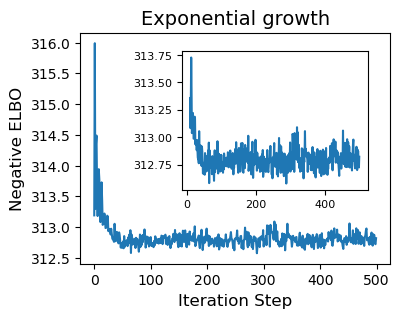

In [74]:
inset_start = 40 if model == 'gompertz' else 10

fig = futil.plot_History(history_VB,model,inset_start,figsize=figsize1,ylabel='Negative ELBO')

save_fig = True
if save_fig:
    if M == 100:
        plt.savefig(f'figs/figS5_{model}.pdf', bbox_inches='tight')

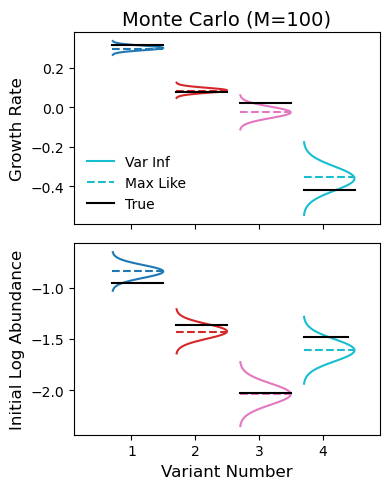

In [75]:
if model == 'exponential':
    if M == 0:
        title = 'Analytical Lower Bound'
    else:
        title = f'Monte Carlo (M={M})'
        
    fig = futil.plot_Gaussians(params_true,params_ML,params_VB,sigmas_VB,model,
                            colors,figsize=figsize2,
                            title=title
                            )

    save_fig = True
    if save_fig:
        plt.savefig(f'figs/fig5_M{M}.pdf', bbox_inches='tight')

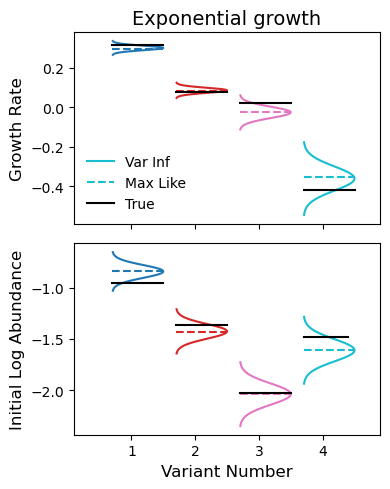

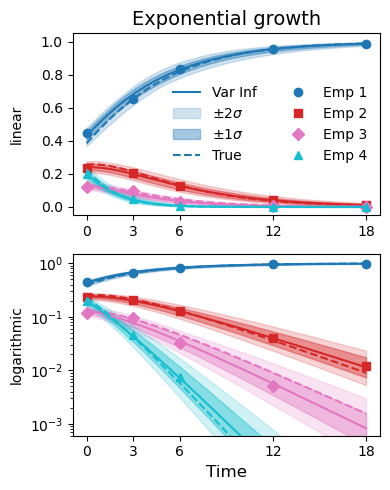

In [76]:
figA = futil.plot_Gaussians(params_true,params_ML,params_VB,sigmas_VB,model,
                           colors,figsize=figsize2)

figB = futil.plot_fractions(reads,params_true,params_VB,['True','Var Inf'],params_time,
                                   model,K_N0,colors,markers,figsize=figsize2,ylabel=False,
                                   sigmas=sigmas_VB,Mtrj=1000)

save_fig = True
if save_fig:
    if not (model == 'exponential' and M != 100):
        figA.savefig(f'figs/fig6a_{model}.pdf', bbox_inches='tight')
        figB.savefig(f'figs/fig6b_{model}.pdf', bbox_inches='tight')

In [77]:
print(growth_rates_true)
print(5*growth_rates_VB)
print(5*(growth_rates_VB-growth_rates_VB.mean()))
print(5*sigmasL_VB,"\n")

print(log_abundances_true)
print(log_abundances_VB)
print(sigmasD_VB)

tensor([ 0.600,  0.361,  0.301, -0.137])
tensor([ 1.508,  0.431, -0.129, -1.810])
tensor([ 1.508,  0.431, -0.129, -1.810])
tensor([0.059, 0.065, 0.144, 0.308]) 

tensor([-0.955, -1.363, -2.026, -1.481])
tensor([-0.843, -1.427, -2.040, -1.612])
tensor([0.063, 0.072, 0.104, 0.109], dtype=torch.float32)


In [78]:
#stop

# Variational Bayes - First time point

### Stochastic (M>0) and lower bound (M=0) approximation to ELBO

In [79]:
lr = 0.03
num_steps = 400
M = 100
jensen_init = True

num_times = 1

F = 100  # Final averaging window

mu_avg100 = torch.zeros((num_times,K))
sig_avg100 = torch.zeros((num_times,K))

for it in range(num_times):
    print(it)
    mu_avg100[it],sig_avg100[it],mus,sigs,history_SVI = futil.first_point_maxELBO(reads,num_steps,lr,M,F,jensen_init)

0


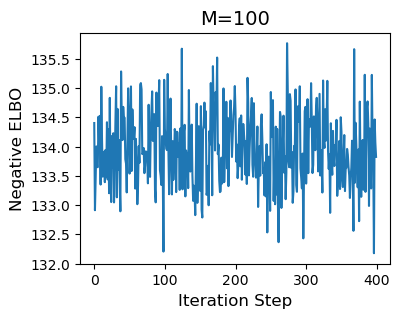

In [80]:
if jensen_init:
    inset_start = -1
else:
    inset_start = 0

fig = futil.plot_History(history_SVI,model,inset_start,figsize=figsize1,ylabel='Negative ELBO',ylim=True,title=f"M={M}")
save_fig = True
if save_fig:
    if num_steps == 1000:
        if num_times == 1:
            if jensen_init:
                plt.savefig(f'figs/figS3_LB_M{M}.pdf', bbox_inches='tight')
            else:
                plt.savefig(f'figs/figS2_M{M}.pdf', bbox_inches='tight')

In [81]:
mean_mu = mu_avg100.mean(dim=0)
std_mu = mu_avg100.std(dim=0, unbiased=False)

torch.set_printoptions(precision=4)  # show 4 decimal places

mean_sig = sig_avg100.mean(dim=0)
std_sig = sig_avg100.std(dim=0, unbiased=False)

print(mean_mu,std_mu)
print(mean_sig,std_sig)

tensor([-0.8029, -1.4472, -2.1351, -1.6168]) tensor([0., 0., 0., 0.])
tensor([0.0975, 0.1119, 0.1598, 0.1297]) tensor([0., 0., 0., 0.])


In [82]:
print(mus)
print(sigs)

tensor([-0.7969, -1.4420, -2.1642, -1.6195], dtype=torch.float32)
tensor([0.1146, 0.1177, 0.1463, 0.1246], dtype=torch.float32)


In [83]:
fold = 2
print(mean_mu+fold*mean_sig)
print(log_abundances_true)
print(mean_mu-fold*mean_sig)


tensor([-0.6080, -1.2233, -1.8155, -1.3575])
tensor([-0.9549, -1.3627, -2.0260, -1.4814])
tensor([-0.9979, -1.6710, -2.4548, -1.8762])


In [84]:
E_lb = torch.zeros(K,K)
V_lb = torch.zeros(K,K)

#mus1 = mus
#sigs1 = sigs
mus1 = mean_mu
sigs1 = mean_sig

sig2 = sigs1**2

for i in range(K):
    for j in range(K):
        E_lb[i,j] = mus1[i] - mus1[j]
        if j != i:
            V_lb[i,j] = sig2[i] + sig2[j]


torch.set_printoptions(precision=3) 

print(E_lb)
print(V_lb)

tensor([[ 0.000,  0.644,  1.332,  0.814],
        [-0.644,  0.000,  0.688,  0.170],
        [-1.332, -0.688,  0.000, -0.518],
        [-0.814, -0.170,  0.518,  0.000]])
tensor([[0.000, 0.022, 0.035, 0.026],
        [0.022, 0.000, 0.038, 0.029],
        [0.035, 0.038, 0.000, 0.042],
        [0.026, 0.029, 0.042, 0.000]])


In [85]:
# delta method approximation for fractions
fx_means = torch.softmax(mean_mu,dim=0)
print(fx_means)

ss = torch.sum( (fx_means * mean_sig)**2)
fx_stds = fx_means * mean_sig * torch.sqrt(1 - 2*fx_means + ss/mean_sig**2)
print(fx_stds)

tensor([0.448, 0.235, 0.118, 0.199])
tensor([0.030, 0.024, 0.018, 0.023])


### Lower bound T=1

In [86]:
ns = reads[:,0]

means_LB = torch.log(ns) - 0.5/ns
shift = torch.logsumexp(means_LB,dim=0) #- torch.log(N0_K)
means_LB -= shift
print(means_LB)

var_LB = 1/ns
sig_LB = torch.sqrt(var_LB)
print(sig_LB)

tensor([-0.804, -1.447, -2.135, -1.616], dtype=torch.float32)
tensor([0.074, 0.102, 0.143, 0.110], dtype=torch.float32)


## Dirichlet

In [87]:
alpha_prior = 1.

alphas = reads[:,0] + alpha_prior
alphas_sum = alphas.sum(dim=0)

f_means = alphas/alphas_sum
f_vars = f_means*(1-f_means)/(alphas_sum+1.)
f_std = torch.sqrt(f_vars)

torch.set_printoptions(precision=3)  # show 3 decimal places
print("True fractions:\n",f_init)
print("Mean fractions:\n",f_means)
print("Std devitation:\n",f_std)
print("Std/Mean:\n",f_std/f_means)

True fractions:
 tensor([0.385, 0.256, 0.132, 0.227])
Mean fractions:
 tensor([0.445, 0.236, 0.120, 0.200], dtype=torch.float32)
Std devitation:
 tensor([0.024, 0.021, 0.016, 0.020], dtype=torch.float32)
Std/Mean:
 tensor([0.055, 0.088, 0.132, 0.098], dtype=torch.float32)


In [88]:
EE = torch.zeros(K,K)
VV = torch.zeros(K,K)

psi0 = torch.digamma(alphas)
psi1 = torch.polygamma(1,alphas)

for i in range(K):
    for j in range(K):
        EE[i,j] =  psi0[i] - psi0[j]
        if j != i:
            VV[i,j] =  psi1[i] + psi1[j]

print(EE)
print(VV)

tensor([[ 0.000,  0.638,  1.316,  0.805],
        [-0.638,  0.000,  0.678,  0.167],
        [-1.316, -0.678,  0.000, -0.511],
        [-0.805, -0.167,  0.511,  0.000]])
tensor([[0.000, 0.016, 0.026, 0.018],
        [0.016, 0.000, 0.030, 0.022],
        [0.026, 0.030, 0.000, 0.032],
        [0.018, 0.022, 0.032, 0.000]])


In [89]:
#stop

# Weighted least squares for EXPONENTIAL growth

In [90]:
alpha_prior = 1.
alphas = reads + alpha_prior
# digamma and trigamma
psi0s = torch.digamma(alphas)
psi1s = torch.polygamma(1,alphas)

In [91]:
rho = 1

num_steps = int(2000)
lr = 0.01

growth_rates_r1,log_abundances_r1,history_WLSQ = futil.optimize_WLSQ(reads,params_time,alpha_prior,rho,
                                                                       lr,num_steps,'log')

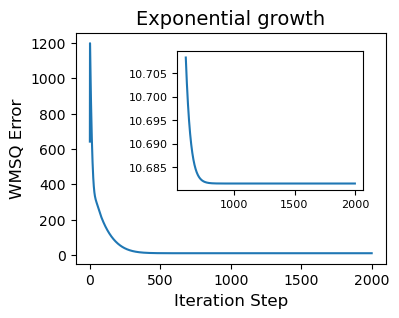

In [92]:
inset_start = 600

fig = futil.plot_History(history_WLSQ,model,inset_start,figsize=figsize1,ylabel='WMSQ Error')

In [93]:
print(growth_rates_r1)
print(growth_rates_r1-growth_rates_r1.mean())
print(growth_rates_r1[:-1]-growth_rates_r1[1:])

tensor([ 0.208,  0.000, -0.097, -0.274])
tensor([ 0.249,  0.041, -0.056, -0.233])
tensor([0.208, 0.097, 0.177])


In [94]:
rho = 3

num_steps = int(2000)
lr = 0.01

growth_rates_r3,log_abundances_r3,history_WLSQ = futil.optimize_WLSQ(reads,params_time,alpha_prior,rho,
                                                                       lr,num_steps,'log')

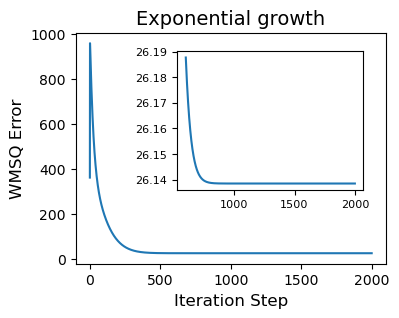

In [95]:
inset_start = 600

fig = futil.plot_History(history_WLSQ,model,inset_start,figsize=figsize1,ylabel='WMSQ Error')

In [96]:
print(growth_rates_r3)
print(growth_rates_r3-growth_rates_r3.mean())

print(growth_rates_r3[:-1]-growth_rates_r3[1:])

tensor([0.474, 0.274, 0.211, 0.000])
tensor([ 0.235,  0.034, -0.028, -0.240])
tensor([0.201, 0.062, 0.211])


In [97]:
import matplotlib.gridspec as gridspec

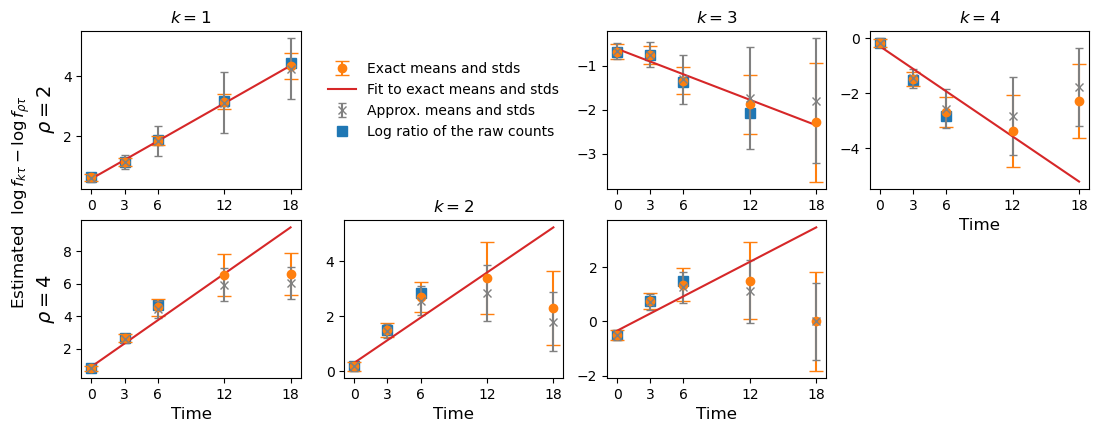

In [98]:
if model == 'exponential':

    alpha_prior = 1.
    alphas = reads + alpha_prior
    # digamma and trigamma
    psi0s = torch.digamma(alphas)
    psi1s = torch.polygamma(1,alphas)

    fig = plt.figure(figsize=(13,4.5))
    rows = 2
    cols = 4
    gs = gridspec.GridSpec(rows, cols)
    k_indx = [0,1,2,3,0,1,2,3] 


    all_handles = []
    all_labels = []

    for indx in range(rows*cols):
        k = k_indx[indx]

        if indx < 4:
            lams = growth_rates_r1
            dels = log_abundances_r1
            rhoL = 1
        else:
            lams = growth_rates_r3
            dels = log_abundances_r3
            rhoL = 3

        fit_fine = lams[:,None]*times_fine[None,:] + dels[:,None]

        log_reads = torch.log(reads/reads[rhoL])
        log_alphas = torch.log(alphas/alphas[rhoL])
        dif_p0 = psi0s-psi0s[rhoL]
        sqrt_p1 = torch.sqrt(psi1s+psi1s[rhoL])

        if k != rhoL:
            ax = plt.subplot(gs[indx])

            line1, = ax.plot(times,log_reads[k],'s',markersize=7,label='Log ratio of the raw counts')
            err2  = ax.errorbar(times,dif_p0[k],sqrt_p1[k],fmt='o', capsize=5,label='Exact means and stds')
            err3  = ax.errorbar(times,log_alphas[k],torch.sqrt(1/alphas[k]+1/alphas[rho]),color='gray',fmt='x', capsize=3,label='Approx. means and stds')
            line4, = ax.plot(times_fine,fit_fine[k],color='C3',label='Fit to exact means and stds')

            # use only the main line/marker from the containers
            line2 = err2.lines[0]; line2.set_label('Exact means and std devs')
            line3 = err3.lines[0]; line3.set_label('Approx. means and stds')

            # grab one instance of each handle/label
            if not all_handles:                 
                all_handles = [err2, line4, err3, line1]
                all_labels  = [h.get_label() for h in all_handles]  # now these are correct

            if indx < 4 or indx == 5:
                ax.set_title(f"$k={k+1}$",fontsize=12)
            if k == 0:
                ax.set_ylabel(f"$\\rho={rhoL+1}$",fontsize=14)

            if indx > 2:
                ax.set_xlabel('Time',fontsize=12)
            ax.set_xticks(times)

    # common y label
    fig.text(0.07, 0.5, r"Estimated  $\log f_{k\tau} - \log f_{\rho\tau}$",fontsize=12, va='center', rotation='vertical')

    # figure-level legend with real handles
    fig.legend(all_handles, all_labels,
            loc='upper left',
            bbox_to_anchor=(0.305, 0.84),
            ncol=1,
            frameon=False,
            fontsize=10)


    save_fig = True
    if save_fig:
        plt.savefig(f'figs/fig3a.pdf', bbox_inches='tight')

    plt.show()

In [99]:
rho = 3

num_steps = int(6000)
lr = 0.05

growth_rates_WLSQ,log_abundances_WLSQ,history_WLSQ = futil.optimize_WLSQ(reads,params_time,alpha_prior,rho,
                                                                       lr,num_steps,'frac')

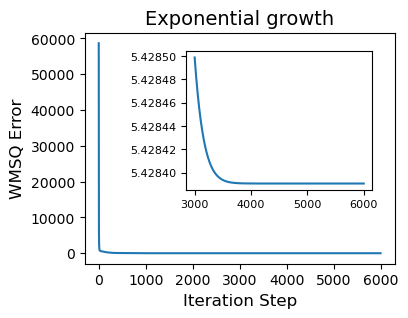

In [100]:
inset_start = 3000

fig = futil.plot_History(history_WLSQ,model,inset_start,figsize=figsize1,ylabel='WMSQ Error')

In [101]:
print(growth_rates_WLSQ)
print(growth_rates_WLSQ-growth_rates_WLSQ.mean())
print(growth_rates_WLSQ[:-1]-growth_rates_WLSQ[1:])

tensor([0.604, 0.401, 0.312, 0.000])
tensor([ 0.275,  0.071, -0.017, -0.329])
tensor([0.204, 0.088, 0.312])


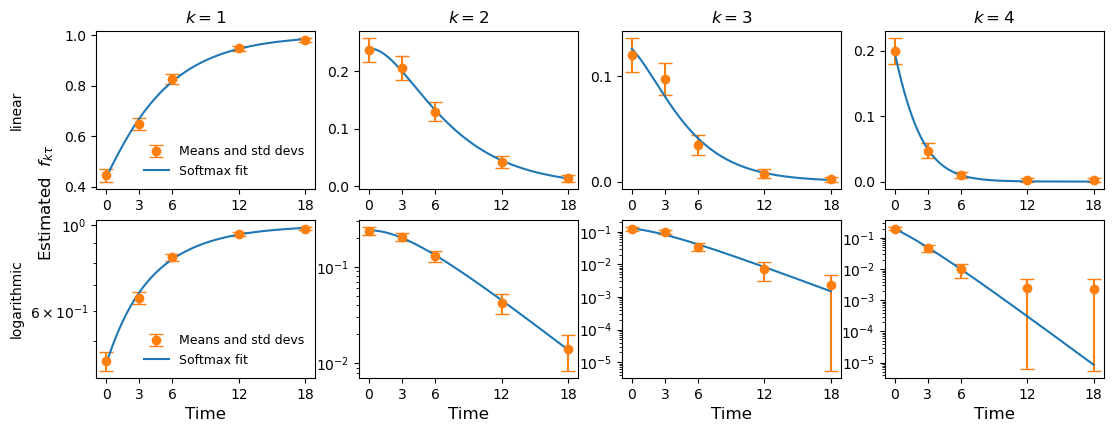

In [102]:
if model == 'exponential':

    alpha_prior = 1.
    alphas = reads + alpha_prior
    alphas_sum = alphas.sum(dim=0)
    # fraction mean and variance 
    f_means = alphas/alphas_sum
    f_vars = f_means*(1-f_means)/(alphas_sum+1)
    f_stds = torch.sqrt(f_vars)

    k_values = [0,1,2,3,0,1,2,3]

    lams = growth_rates_WLSQ
    dels = log_abundances_WLSQ

    ys_fine = lams[:,None]*times_fine[None,:] + dels[:,None]
    phis_fine = torch.softmax(ys_fine,dim=0)

    fig = plt.figure(figsize=(13,4.5))
    rows = 2
    cols = 4
    gs = gridspec.GridSpec(rows, cols)

    all_handles = []
    all_labels = []

    for idx in range(rows*cols):
        ax = plt.subplot(gs[idx])
        k = k_values[idx]

        err2 = ax.errorbar(times,f_means[k],f_stds[k],fmt='o',capsize=5,color='C1',label='Means and std devs')
        line4, = ax.plot(times_fine,phis_fine[k],color='C0',label='Softmax fit')           

        if idx == 0: 
            ax.set_ylabel('linear')
            ax1 = ax

            handles = [err2, line4]  # <- desired order
            labels  = [h.get_label() for h in handles]
            ax.legend(handles, labels, frameon=False, fontsize=9,loc='lower right')
        elif idx == cols:
            ax.set_ylabel('logarithmic')
            ax2 = ax

            handles = [err2, line4]  # <- desired order
            labels  = [h.get_label() for h in handles]
            ax.legend(handles, labels, frameon=False, fontsize=9,loc='lower right')
         
        if idx < cols:
            ax.set_title(f"$k={k+1}$",fontsize=12)
            if idx == 0:
                ax.yaxis.set_major_locator(MultipleLocator(0.2))
            else:
                ax.yaxis.set_major_locator(MultipleLocator(0.1))
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        else:
            ax.set_yscale("log")
            ax.set_xlabel('Time',fontsize=12)
        ax.set_xticks(times)

    fig.align_ylabels([ax1, ax2])
    # common y label
    fig.text(0.08, 0.5, r"Estimated  $f_{k\tau}$",fontsize=12, va='center', rotation='vertical')

    # figure-level legend with real handles
    fig.legend(all_handles, all_labels,
            loc='upper left',
            bbox_to_anchor=(0.5, 0.8),
            ncol=1,
            frameon=False,
            fontsize=10)


    save_fig = True
    if save_fig:
        plt.savefig(f'figs/fig3b.pdf', bbox_inches='tight')

    plt.show()